# **Melanoma Detection Assignment**

=======================================================================================================================

## **Problem Statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


#### **Data set contains the following diseases:**

<li>Actinic keratosis</li>
<li>Basal cell carcinoma</li>
<li>Dermatofibroma</li>
<li>Melanoma</li>
<li>Nevus</li>
<li>Pigmented benign keratosis</li>
<li>Seborrheic keratosis</li>
<li>Squamous cell carcinoma</li>
<li>Vascular lesion</li>


#### **Project Pipeline:**

<li>Importing all the important libraries</li>
<li>Data Reading/Data Understanding</li>
<li>Dataset Creation</li>
<li>Dataset visualisation</li>
<li>Model Building & training</li>
<li>Chose an appropriate data augmentation strategy to resolve underfitting/overfitting</li>
<li>Model Building & training on the augmented data</li>
<li>Class distribution</li>
<li>Handling class imbalances</li>
<li>Model Building & training on the rectified class imbalance data</li>

===================================================================================================================

### **Importing all the important libraries**

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential
from google.colab import drive
from glob import glob
from sklearn.preprocessing import LabelEncoder
from collections import Counter

### **Data Reading/Data Understanding**

In [2]:
# Google Drive mount - Reading image dataset from Google Drive by unzipping the zip
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/CNN_assignment

Mounted at /content/gdrive
Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707

<li>This dataset has 2357 images of skin cancer types.</li>
<li>The dataset contains 9 sub-directories in each train and test subdirectories.</li>
<li>The 9 sub-directories contains the images of 9 skin cancer types respectively.</li>

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [4]:
# Checking the total count of Train and Test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total Train Images = ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total Test Images = ",image_count_test)

Total Train Images =  2239
Total Test Images =  118


### **Dataset Creation**

In [5]:
# Defining parameters as given in the prblem statement for the loader:
batch_size = 32
img_height = 180
img_width = 180

<li>Using 80% of the images for training, and 20% for validation.</li>

In [6]:
# Train dataset:
# Taking seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# Also, resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Test dataset:
# Taking seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# Also, resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print("Class Name = ",class_names)

Class Name =  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Dataset Visualisation**

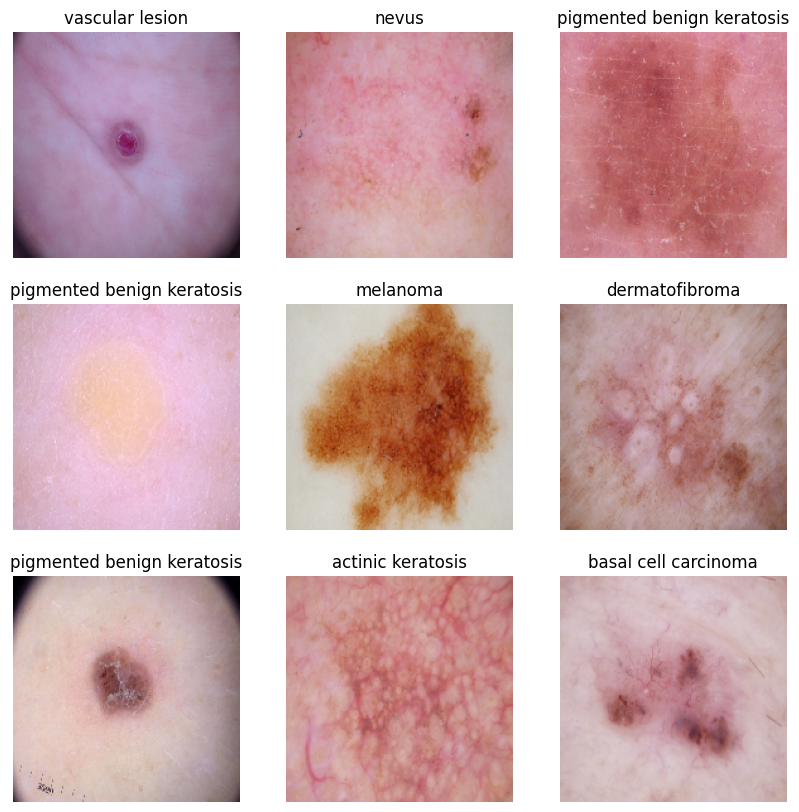

In [9]:
# Visualizing one instance of all the 9 classes present in the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they are loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Creating the Model 1**


#### Creating a CNN model, which can accurately detect 9 classes present in the dataset using  ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Creating a CNN model, which can accurately detect 9 classes present in the dataset
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### **Compiling the Model**

In [12]:
# Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Training the Model**

In [14]:
# Training model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 113ms/step - loss: 1.9443 - accuracy: 0.3002 - val_loss: 1.6163 - val_accuracy: 0.4452
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6355 - accuracy: 0.4096 - val_loss: 1.5281 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4529 - accuracy: 0.4794 - val_loss: 1.4251 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3700 - accuracy: 0.5218 - val_loss: 1.3828 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2677 - accuracy: 0.5458 - val_loss: 1.3420 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1677 - accuracy: 0.5910 - val_loss: 1.2945 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.1055 - accuracy: 0.6094 - val_loss: 1.4510 - val_accuracy: 0.5034
Epoch 8/20


### **Visualizing Training Results**

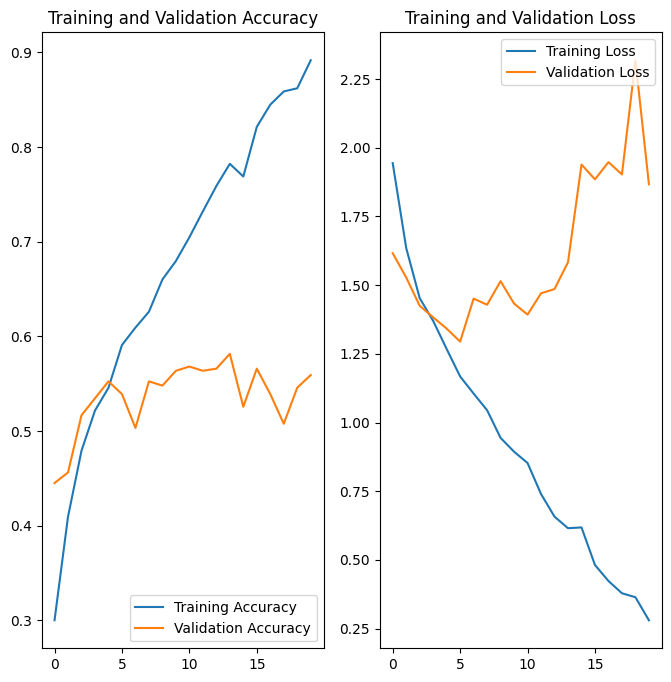

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Here are the findings after the model fit experiment 1**

<li>Model is overfitting as there is a discernible gap in the loss functions between the training and test sets, particularly noticeable after the 8th epoch.</li>

<li>Model accuracy is around 90%, indicating that the model might be grappling with an abundance of features, attempting to memorize patterns rather than generalizing effectively.</li>

#### **Choosing an appropriate data augumentation strategy.**

In [16]:
# Choosing an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

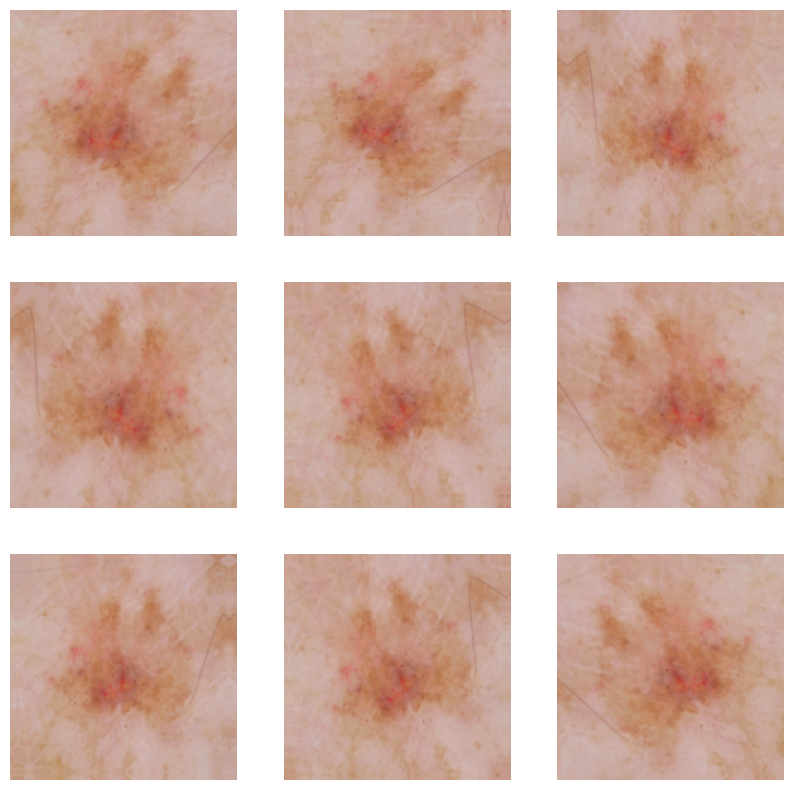

In [17]:
# Visualize augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### **Creating the Model 2**


In [18]:
# Dropping out layer as there is an evidence of overfitting in previous findings
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### **Compiling the Model**

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Training the Model**

In [20]:
## Training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 35ms/step - loss: 2.0075 - accuracy: 0.2656 - val_loss: 1.7530 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6798 - accuracy: 0.4007 - val_loss: 1.6337 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6327 - accuracy: 0.4297 - val_loss: 1.8165 - val_accuracy: 0.3400
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5324 - accuracy: 0.4643 - val_loss: 1.4455 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4239 - accuracy: 0.5078 - val_loss: 1.4157 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3961 - accuracy: 0.5145 - val_loss: 1.4322 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3369 - accuracy: 0.5251 - val_loss: 1.4226 - val_accuracy: 0.4989
Epoch 8/20
56

### **Visualizing the Results**

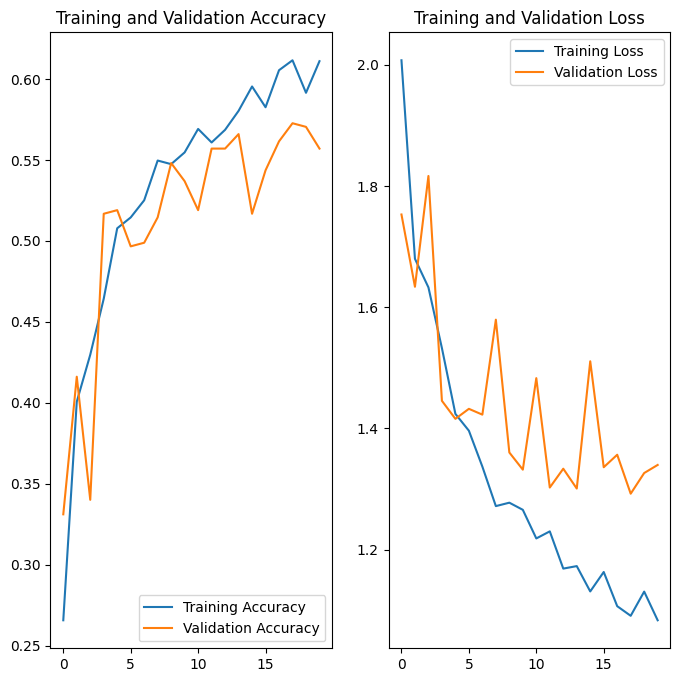

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Here are the findings after the model fit experiment 2**

<li>There is no improvement in accuracy but overfitting problem has solved due to data augmentation.</li>
<li>Increasing the epochs may increase the accuracy</li>

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
# Total Train image in dataset
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("Total Train image = ",len(path_list))

Total Train image =  2239


In [23]:
# Creating new dataset with Path and Label
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,melanoma
2235,Skin cancer ISIC The International Skin Imagin...,melanoma
2236,Skin cancer ISIC The International Skin Imagin...,melanoma
2237,Skin cancer ISIC The International Skin Imagin...,melanoma


In [24]:
# Spliting into input and output elements
X, y = original_df['Path'], original_df['Label']

In [25]:
# Label encode the target variable
y = LabelEncoder().fit_transform(y)

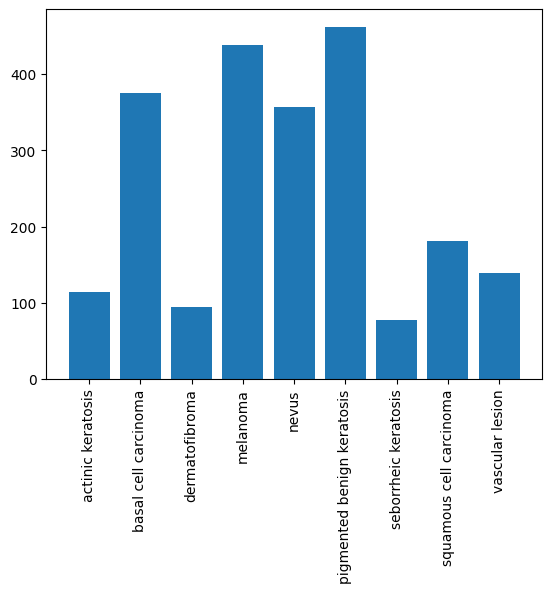

In [26]:
# Summarize distribution
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

plt.tick_params(axis='x', labelrotation=90)
plt.bar(class_names,count)
plt.show()

#### **Here are the findings**

#### - Which class has the least number of samples?
**Ans -  Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**Ans -  Pigmented benign keratosis**

#### **Rectify the class imbalance**

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
!pip install Augmentor

In [28]:
# import Augmentor
import Augmentor

In [29]:
# Augmentor
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788F38A7B940>: 100%|██████████| 500/500 [00:18<00:00, 26.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788F38AE3460>: 100%|██████████| 500/500 [00:21<00:00, 23.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788F38B2FA30>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x788FA00E9600>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x788F389064A0>: 100%|██████████| 500/500 [01:14<00:00,  6.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788F5B90D630>: 100%|██████████| 500/500 [00:16<00:00, 30.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788FA00EB940>: 100%|██████████| 500/500 [00:37<00:00, 13.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788F38BE6110>: 100%|██████████| 500/500 [00:17<00:00, 28.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x788FA04D4CA0>: 100%|██████████| 500/500 [00:14<00:00, 33.51 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
image_count_train

4500

### **Lets see the distribution of augmented data after adding new images to the original training data**

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_18e3db0f-157e-4184-97eb-8da22ad89219.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_a4de5dc5-d355-4cd6-8c3d-36f7e72e1e04.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_af01ae51-86fa-40a1-a1d4-d0571f3ca3c0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_6ff5c4c4-ccbc-4b7c-84e4-d5e5a9880d7a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_70f69a3f-45d3-4317-94d0-181314c7d37e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
# Creating new dataset after adding more samples to  the classes
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-33-c713b42afe05>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [34]:
# Total sample count after dding more samples to the classes
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Training the model on the data created using Augmentor**

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Creating a training dataset**

In [36]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train") #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Creating a validation dataset**

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Creating Model 3 with  Normalization**

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Compiling Model with Optimizer and Loss function**

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Training model**

In [40]:
# Train model using 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 58ms/step - loss: 1.8583 - accuracy: 0.2880 - val_loss: 1.5342 - val_accuracy: 0.4232
Epoch 2/30
169/169 [==============================] - 4s 25ms/step - loss: 1.4060 - accuracy: 0.4755 - val_loss: 1.4056 - val_accuracy: 0.4618
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.1844 - accuracy: 0.5530 - val_loss: 1.1329 - val_accuracy: 0.5702
Epoch 4/30
169/169 [==============================] - 4s 25ms/step - loss: 1.0133 - accuracy: 0.6285 - val_loss: 1.0136 - val_accuracy: 0.6333
Epoch 5/30
169/169 [==============================] - 4s 25ms/step - loss: 0.8427 - accuracy: 0.6907 - val_loss: 1.0615 - val_accuracy: 0.6184
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.7260 - accuracy: 0.7398 - val_loss: 0.8648 - val_accuracy: 0.7030
Epoch 7/30
169/169 [==============================] - 4s 25ms/step - loss: 0.5759 - accuracy: 0.7949 - val_loss: 0.8148 - val_accuracy: 0.727

#### **Visualizing the model results**

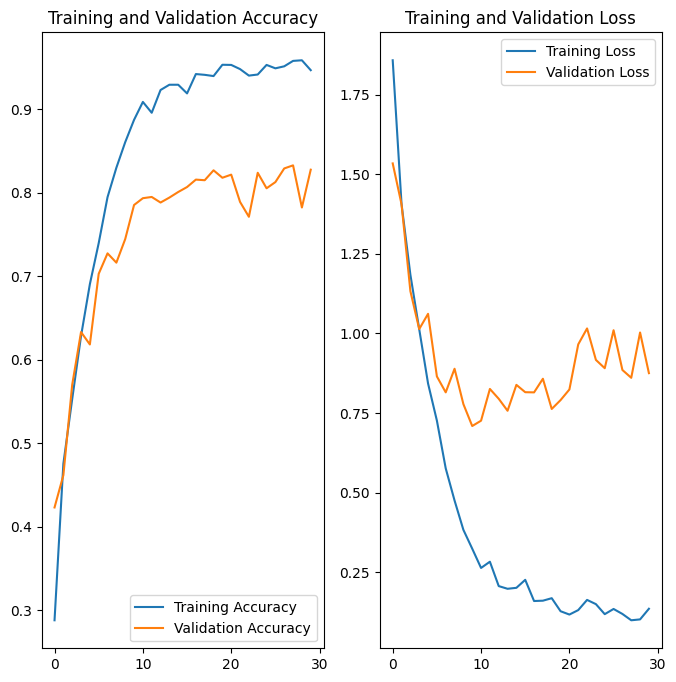

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Drawing Conclusions and Analyzing Results**

<li>Accuracy on training data has increased by using Augmentor library</li>
<li>Model is still overfitting</li>
<li>Problem of overfitting can be solved by adding more layer, neurons or adding dropout layers.</li>
<li>Model can be further improved by tuning the hyperparameter</li>




